# Structure learning of sampled data 

## Load 1000 samples generated from Student performance Bayesian network

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyAgrum as gum
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn

pd.set_option('display.max_rows', 15)

# load dataset
df = pd.read_csv("datasets/sampled_student_prediction.csv")
df

,A,D,G,ST1,J,ST2,S,T,E,H,P,Att,R,L
0,18-21,sometimes,fail,alone,no,last moment,male,sometimes,no,None,high school,always,yes,rental
1,18-21,always,pass,alone,no,last moment,male,sometimes,no,6-10 hours,university,always,no,dormitory
2,22-25,sometimes,pass,alone,no,regularly,female,always,no,<5 hours,high school,always,no,dormitory
3,22-25,always,pass,alone,no,last moment,male,always,no,<5 hours,high school,always,yes,rental
4,18-21,sometimes,pass,alone,yes,last moment,male,always,no,None,high school,sometimes,no,with family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22-25,sometimes,pass,alone,no,last moment,male,sometimes,yes,<5 hours,university,always,no,dormitory
996,22-25,always,fail,not applicable,no,last moment,male,always,no,<5 hours,MSc.,always,yes,dormitory
997,18-21,always,pass,with friends,yes,last moment,male,always,no,None,university,always,yes,dormitory
998,22-25,always,fail,alone,no,last moment,female,always,no,<5 hours,secondary school,sometimes,yes,rental


## Load target BN

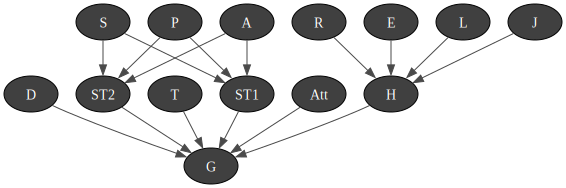

In [89]:
# load target structure
bn_target = gum.loadBN("student_performance_BN.xdsl")
gnb.showBN(bn_target, size=20)

## Create template BN with the same variables as target

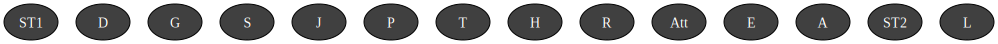

In [92]:
temp = gum.BayesNet("Structure learning - Student Performance network")

for name in bn_target.names():
    temp.add(bn_target.variableFromName(name))

gnb.showBN(temp, size=20)

## Learn structure of samples (100, 500, 1000)

In [69]:

sample_sizes = [100, 500, 1000]
bns_ghc = []
bns_micc = []

for size in sample_sizes:
    learner_ghc = gum.BNLearner(df.sample(size), temp)
    learner_ghc.useGreedyHillClimbing()
    bns_ghc.append(learner_ghc.learnBN())

for size in sample_sizes:
    learner_micc = gum.BNLearner(df.sample(size), temp)
    learner_micc.useMIIC()
    bns_micc.append(learner_micc.learnBN())


In [70]:
gnb.flow.row(*bns_ghc, captions=[f"sample size: {x}" for x in sample_sizes])

In [71]:
gnb.flow.row(*bns_micc, captions=[f"sample size: {x}" for x in sample_sizes])

## Analysis
evaluation metrics: 
- structural hamming distance (SHD)
- Euclidean distance
- Balanced Scoring Function (BSF) 

In [87]:
ghc_cmp = bnvsbn.GraphicalBNComparator(bns_ghc[2], bn_target)

# gnb.flow.add(bnvsbn.graphDiff(bns_micc[2], bn_target))
# gnb.flow.add(bnvsbn.graphDiffLegend())

gnb.flow.add(bnvsbn.graphDiff(bns_micc[2], bn_target), "test")

gnb.flow.display()

In [85]:
gcmp.hamming()

{'hamming': 10, 'structural hamming': 12}

In [154]:
gnb.flow.row(*bns_micc, captions=[f"sample size: {x}" for x in sample_sizes])

In [156]:
learner = gum.BNLearner(df, temp)
learner.useMIIC()
learner

(pyAgrum.BNLearner<double>@0x2ecad39c6e0) Filename       : C:\Users\janba\AppData\Local\Temp\tmp984nfgir.csv
Size           : (1000,14)
Variables      : S[2], D[3], ST1[3], G[2], J[2], P[6], T[3], H[5], R[2], Att[3], E[2], A[3], ST2[3], L[4]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

In [172]:
bn_out = learner.learnBN()
gnb.flow.row(bn_out, bnvsbn.graphDiff(bn_out, bn_target), explain.getInformation(bn_out),captions=["Learned BN", "diff", "information"])

In [181]:
{(bn_out.variable(f).name(), bn_out.variable(t).name()) for (f, t) in bn_out.arcs()}

{('A', 'ST2'),
 ('E', 'H'),
 ('G', 'D'),
 ('J', 'H'),
 ('R', 'H'),
 ('S', 'ST1'),
 ('ST1', 'G'),
 ('ST2', 'ST1')}

In [183]:
get_arcs = lambda bn: {(bn.variable(f).name(), bn.variable(t).name()) for (f, t) in bn.arcs()}

present_edges = get_arcs(bn_out).intersection(get_arcs(bn_target))
absent_edges  = get_arcs(bn_target) - get_arcs(bn_out)



{('A', 'ST1'),
 ('Att', 'G'),
 ('D', 'G'),
 ('H', 'G'),
 ('L', 'H'),
 ('P', 'ST1'),
 ('P', 'ST2'),
 ('S', 'ST2'),
 ('ST2', 'G'),
 ('T', 'G')}

In [25]:


for bn in bns:
    bn_diff = gum.ExactBNdistance(bn, bn_target)
    bn_diff.compute()
    
bn_diff = gum.ExactBNdistance(bns[0], bn_target)
x = bn_diff.compute()
x

{'klPQ': 0.04825953609924101,
 'errorPQ': 2246176,
 'klQP': 0.5415268566410911,
 'errorQP': 0,
 'hellinger': 0.4874675250144912,
 'bhattacharya': 0.1264839800988992,
 'jensen-shannon': 0.13640091192475093}

## testing

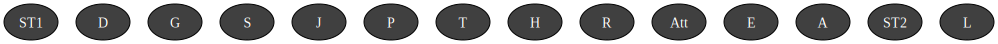

(None,)

In [97]:
gnb.showBN(temp, size=20)

In [203]:
(N * (N-1))/2 - present_edges

91.0

In [209]:
get_arcs = lambda bn: {(bn.variable(f).name(), bn.variable(t).name()) for (f, t) in bn.arcs()}

N = bn_target.size()

hamming_ghc = []
skeleton_ghc = []
bsf_ghc = []

for size in range(1, 1000):
    learner_ghc = gum.BNLearner(df.sample(size), temp)
    learner_ghc.useGreedyHillClimbing()
    bn = learner_ghc.learnBN()

    cmp = bnvsbn.GraphicalBNComparator(bn_target, bn)
    skeleton_scores = cmp.skeletonScores()
    skeleton_ghc.append(skeleton_scores)
    hamming_ghc.append(cmp.hamming()["structural hamming"])

    cm = skeleton_scores["count"]
    present_edges = len(get_arcs(bn).intersection(get_arcs(bn_target)))
    absent_edges  = (N * (N-1))/2 - present_edges
    if absent_edges == 0 or present_edges == 0: continue
    bsf = (cm["tp"]/present_edges + 
           cm["tn"]/absent_edges + 
           cm["fp"]/absent_edges + 
           cm["fn"]/present_edges)/2
    bsf_ghc.append([size, bsf])

hamming_micc = []
skeleton_micc = []
bsf_micc = []

for size in range(1, 1000):
    learner_ghc = gum.BNLearner(df.sample(size), temp)
    learner_ghc.useMIIC()
    bn = learner_ghc.learnBN()
    
    cmp = bnvsbn.GraphicalBNComparator(bn_target, bn)
    skeleton_scores = cmp.skeletonScores()
    skeleton_micc.append(skeleton_scores)
    hamming_micc.append(cmp.hamming()["structural hamming"])

    cm = skeleton_scores["count"]
    present_edges = len(get_arcs(bn).intersection(get_arcs(bn_target)))
    absent_edges  = (N * (N-1))/2 - present_edges
    if absent_edges == 0 or present_edges == 0: continue
    bsf = (cm["tp"]/present_edges + 
           cm["tn"]/absent_edges + 
           cm["fp"]/absent_edges + 
           cm["fn"]/present_edges)/2
    bsf_micc.append([size, bsf])


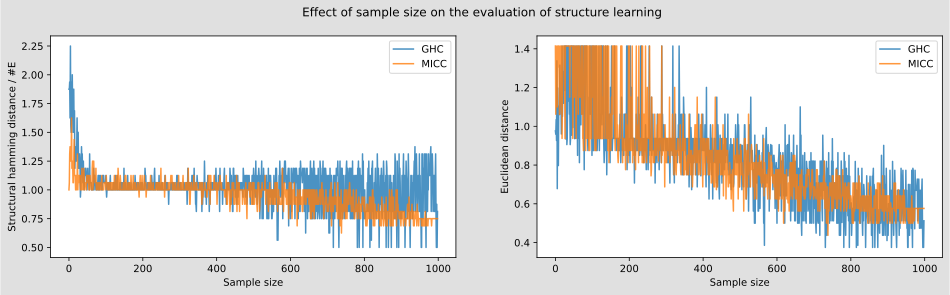

In [232]:
extract_dict_member = lambda d, key: list(map(lambda x: x[key], d))

dist_micc = extract_dict_member(skeleton_micc, "dist2opt")
dist_ghc = extract_dict_member(skeleton_ghc, "dist2opt")

figs, axes = plt.subplots(1, 2, figsize=(16, 4))

plt.suptitle("Effect of sample size on the evaluation of structure learning")
axes[0].plot(np.array(hamming_ghc)/len(bn_target.arcs()),  label="GHC" , alpha=0.8)
axes[0].plot(np.array(hamming_micc)/len(bn_target.arcs()), label="MICC", alpha=0.8)
axes[0].set_xlabel("Sample size")
axes[0].set_ylabel("Structural hamming distance / #E")
axes[0].legend()

axes[1].plot(dist_ghc,  label="GHC" , alpha=0.8)
axes[1].plot(dist_micc, label="MICC", alpha=0.8)
axes[1].set_xlabel("Sample size")
axes[1].set_ylabel("Euclidean distance")
axes[1].legend()

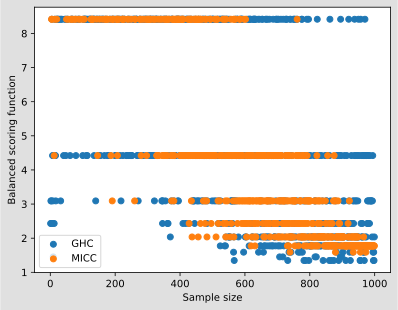

In [263]:
bsf_ghc_np = np.array(bsf_ghc)
bsf_micc_np = np.array(bsf_micc)

plt.scatter(bsf_ghc_np[:, 0], bsf_ghc_np[:, 1], label="GHC")
plt.scatter(bsf_micc_np[:, 0], bsf_micc_np[:, 1], label="MICC")
# plt.plot(bsf_micc, label="MICC", alpha=0.8)
plt.xlabel("Sample size")
plt.ylabel("Balanced scoring function")
plt.legend()

In [265]:
bsf_ghc_np[:, 1].shape

(767,)

In [269]:
bsf_micc_np.shape

(620, 2)

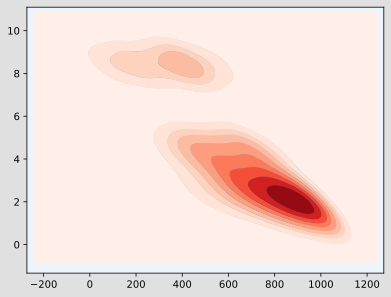

In [276]:
sns.kdeplot(x=bsf_ghc_np[:, 0], y=bsf_ghc_np[:, 1], cmap="Blues", thresh=0 , fill=True)
sns.kdeplot(x=bsf_micc_np[:, 0], y=bsf_micc_np[:, 1], cmap="Reds", thresh=0, fill=True)
plt.show()

c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\seaborn\axisgrid.py:1826: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'stat_func'
  cset = contour_func(


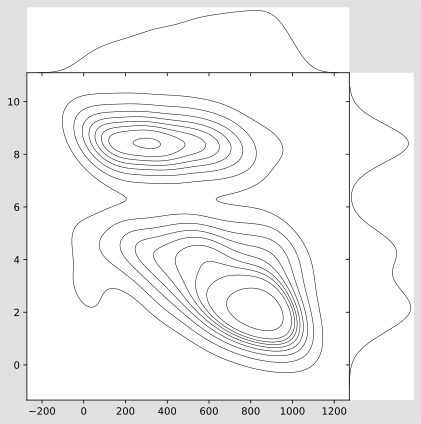

In [277]:
sns.jointplot(x=bsf_ghc_np[:, 0], y=bsf_ghc_np[:, 1], kind="kde", space=0, stat_func=None, marginal_kws={"color":"black", "lw":0.5}, joint_kws={"colors":"black","cmap":None, "linewidths":0.5}, shade=False, n_levels=10)

c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\seaborn\axisgrid.py:1826: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
c:\Users\janba\anaconda3\envs\ktai\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'stat_func'
  cset = contour_func(


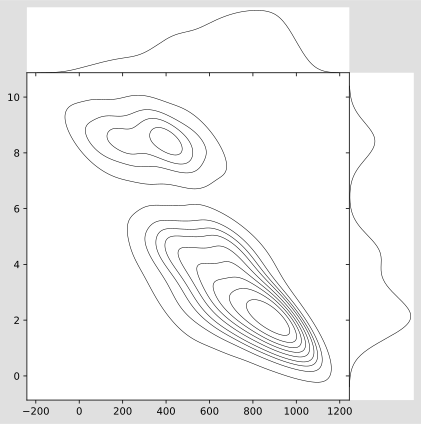

In [278]:
sns.jointplot(x=bsf_micc_np[:, 0], y=bsf_micc_np[:, 1], kind="kde", space=0, stat_func=None, marginal_kws={"color":"black", "lw":0.5}, joint_kws={"colors":"black","cmap":None, "linewidths":0.5}, shade=False, n_levels=10)